In [1]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__) # should be >= 1.7.1


Torch version: 2.0.1+cu117


In [2]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [3]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [4]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7ff2fcfea0d0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [47]:
import os
from PIL import Image
import pickle

outpath = "outputs/clip/embeddings_right.pkl"
imagespath = "images_split/"

# schema {<image_path>: <output>, ...}
try:
    with open(outpath,"rb") as f:
        outputs = pickle.load(f)
except Exception:
    print("starting from zero")
    outputs = {}

files = [f for f in os.listdir(imagespath) if "_BUT" in f]
redo_files = []
original_images, images, image_paths = [], [], []
for filename in files:
    if filename in outputs and filename not in redo_files:
        continue
    image = Image.open(os.path.join(imagespath,filename)).convert('RGB')
    original_images.append(image)
    images.append(preprocess(image))
    image_paths.append(os.path.join(imagespath,filename))

print(f"Doing {len(images)} images at once")

starting from zero
Doing 283 images at once


In [48]:
image_input = torch.tensor(np.stack(images)).cuda()

In [49]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()

In [50]:
for path, embedding in zip(image_paths, image_features):
    outputs[path] = embedding

print(len(outputs))

283


In [51]:
with open(outpath, "wb") as f:
    pickle.dump(outputs,f)

In [52]:
del image_input

# [Sanity Check] Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [24]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169001437/169001437 [00:16<00:00, 10226380.92it/s]


Extracting /home/abhilash_pg/.cache/cifar-100-python.tar.gz to /home/abhilash_pg/.cache


In [53]:
normed_image_features = image_features / image_features.norm(dim=-1, keepdim=True)

In [54]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * normed_image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

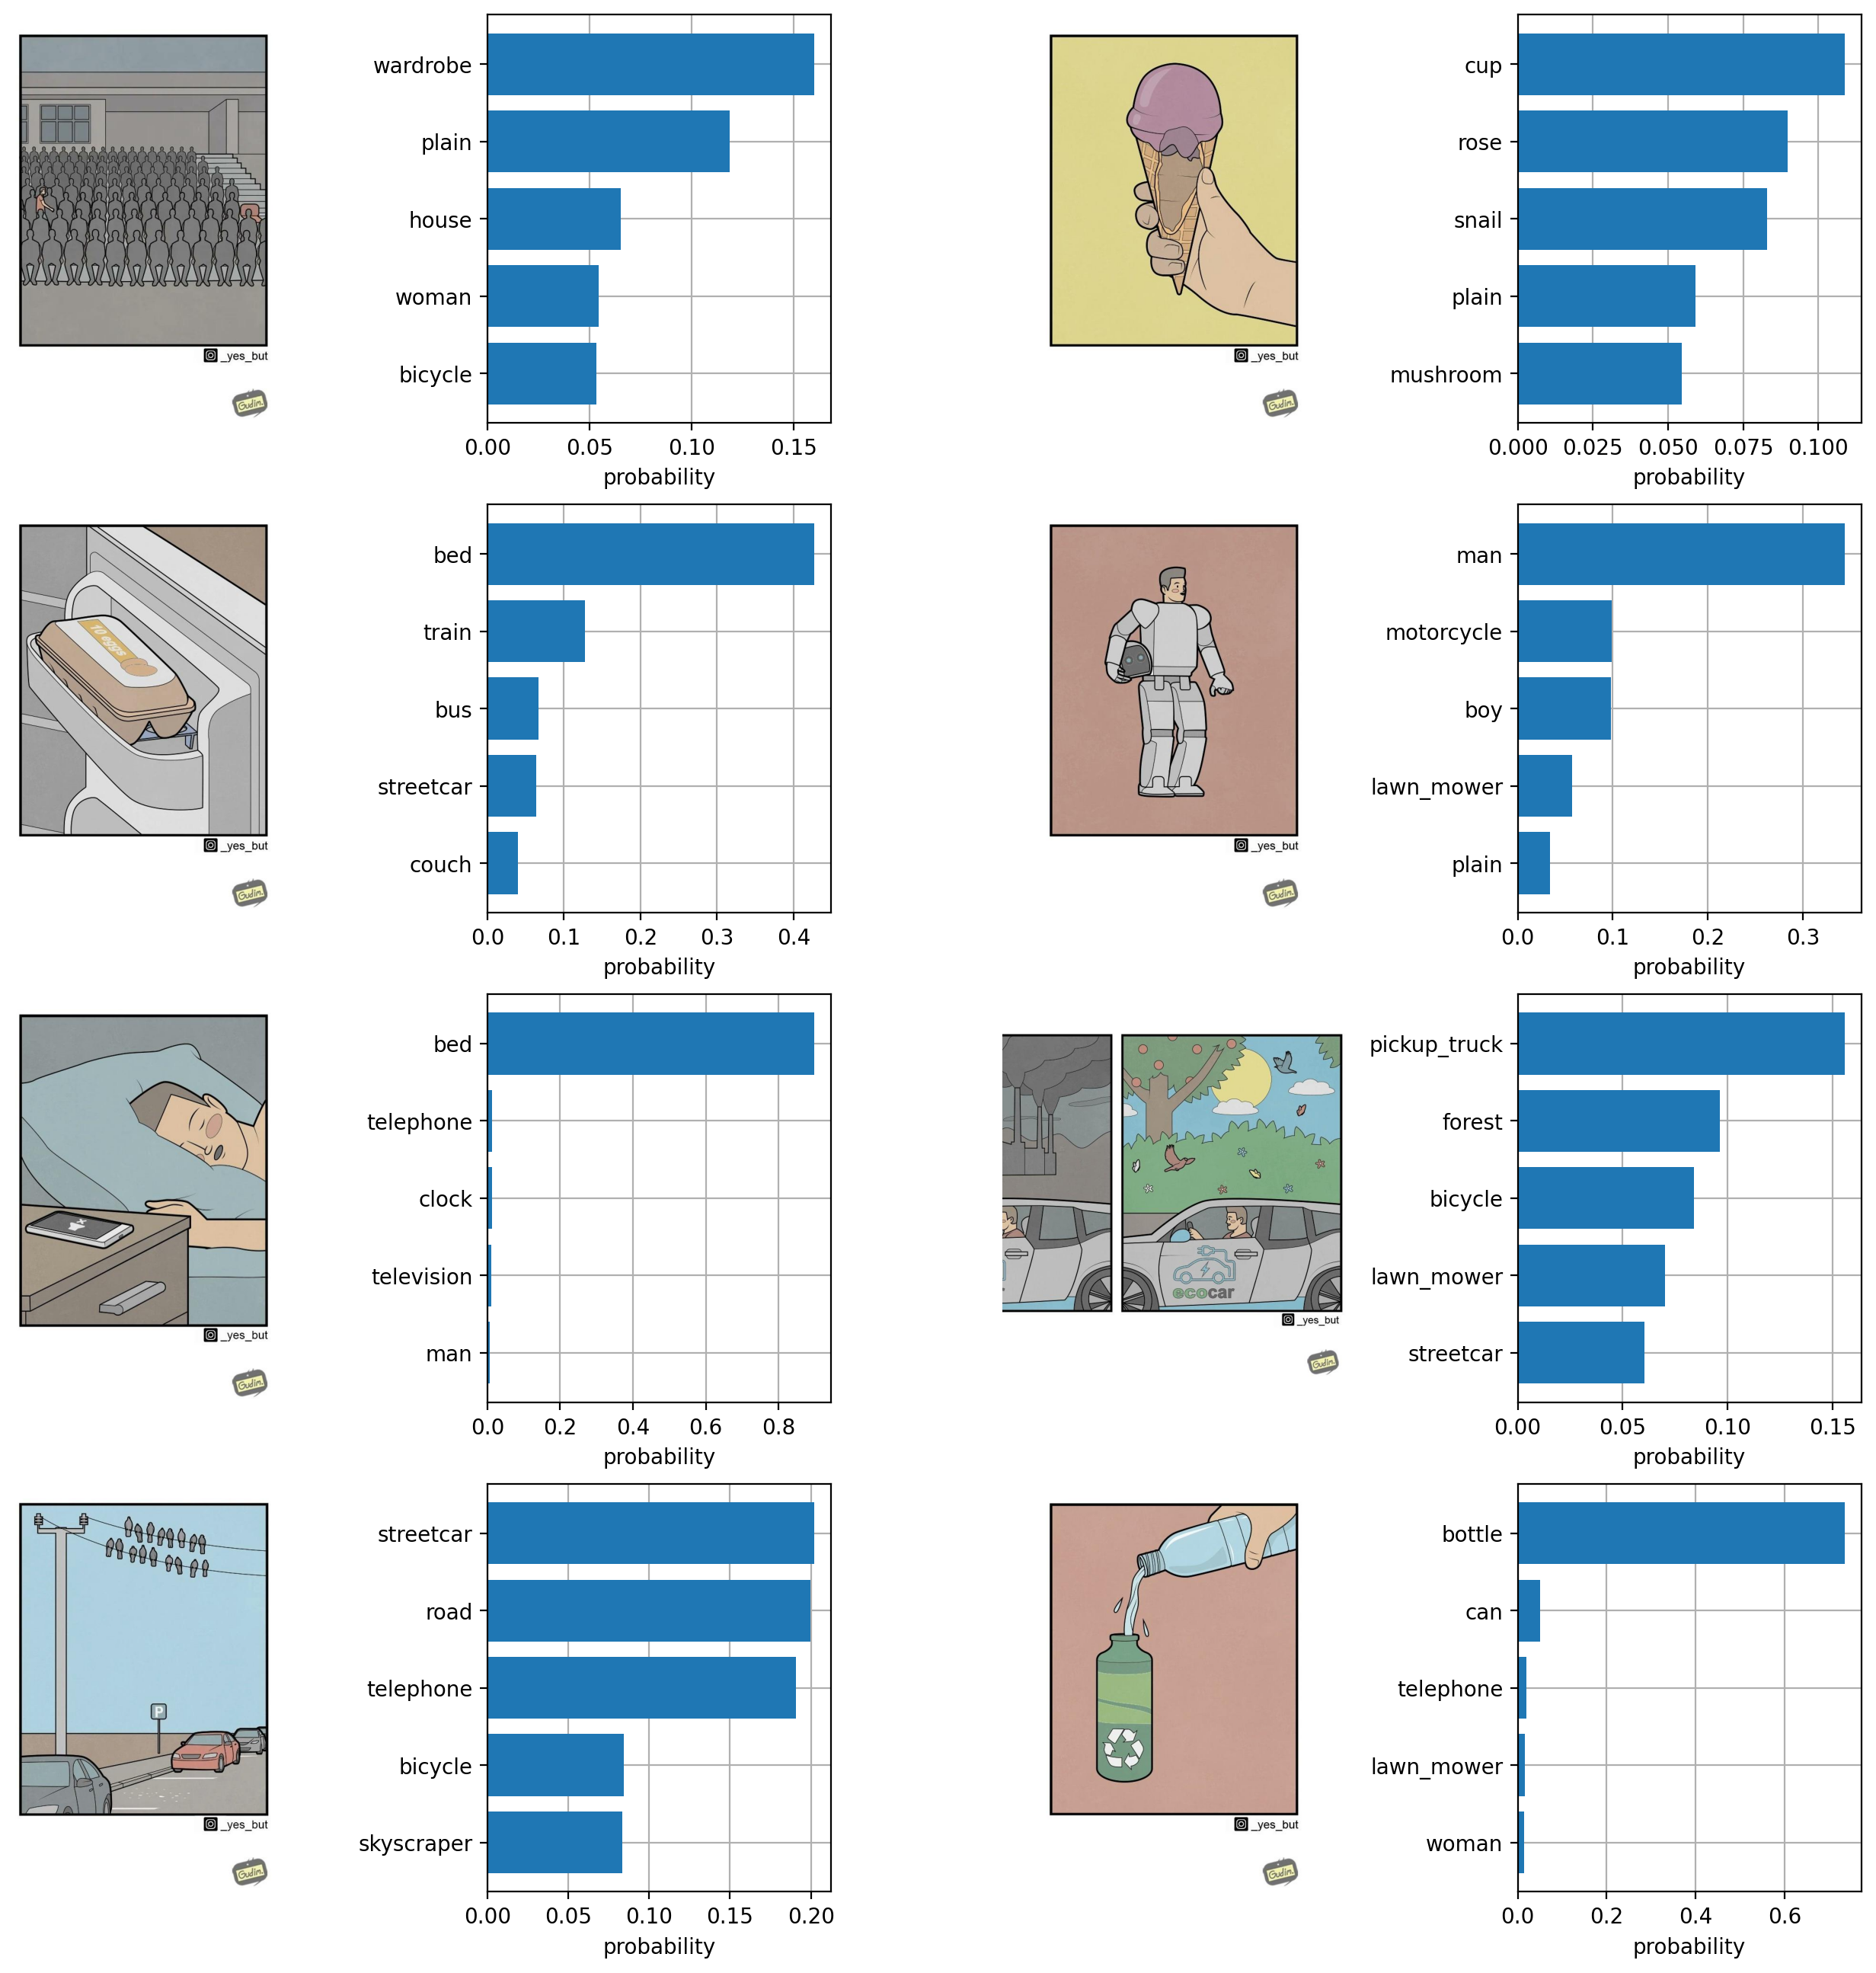

In [58]:
import IPython.display
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(16, 16))

batch = 3
for i, image in enumerate(original_images[batch*8:(batch+1)*8]):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i+batch*8])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i+batch*8].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()